# Hybrid assemblies analysis

In [29]:
import os
import numpy as np
import pandas as pd
from datetime import date
today = date.today()

print(f'Aniket Mane & Cedric Chauve\n{today}')

Aniket Mane & Cedric Chauve
2022-10-07


## Overview

This document contains a very preliminary analysis of the the *Enterococcus* data sets. 
It focuses on two questions:
- accuracy of using the hybrid assemblies to define ground truth plasmids;
- performances of plasmid prediction methods on the data sets.

The main outcome of the first part of the analysis is that the hybrid assembliers do not provide an accurate source for esablishing plasmids ground truth, thus rending the second part much less informative.

In [8]:
#!pip install matplotlib

In [9]:
import matplotlib
import matplotlib.pyplot as plt

In [10]:
# Datasets statistics files
Efaecalis_isolates = 'isolate_details_Efaecalis.csv'
Efaecium_isolates = 'isolate_details_Efaecium.csv'
Efaecalis_contigs = 'ctg_details_Efaecalis.csv'
Efaecium_contigs = 'ctg_details_Efaecium.csv'

## Data

The statistics about hybrid assemblies are available in the files `ctg_details_Efaecalis.csv` and `ctg_details_Efaecium.csv`.

The results of **HyAsP**, **MOBSuite** and **PlasBin** are available in the files `isolate_details_Efaecalis.csv` and `isolate_details_Efaecium.csv`.

## Labelling hybrid contigs

The goal of labelling hybrid contigs is to identify which such contigs are likely plasmid contigs, in order they can be used to define the ground truth for the short-reads assemblies, through mapping short-reads contigs onto hybrid contigs.

For each species, we determine, from the length distribution of the circular hybrid contigs for all isolates, a **threshold L** that separates short circular contigs (plasmids) from other contigs (chromosomes).

Then we assign a class to each hybrid contig as follows:
- circular contigs of length at most **L** are labelled as plasmids;
- TO COMPLETE


## E. faecalis

We present our analysis of the *E. faecalis* isolates.

In [107]:
# Reading hybrid contigs details.
EFAECALIS_CONTIGS = pd.read_csv('ctg_details_Efaecalis.csv')
EFAECALIS_CONTIGS_NB = len(EFAECALIS_CONTIGS)
EFAECALIS_NB_SAMPLES = len(EFAECALIS_CONTIGS['SRA'].value_counts())
# Plasmid contigs
EFAECALIS_PLASMIDS = EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS['classification'] == 'plasmid')]
EFAECALIS_NB_PLASMIDS = EFAECALIS_PLASMIDS.shape[0]
EFAECALIS_NB_PLASMIDS_SAMPLES = len(EFAECALIS_PLASMIDS['SRA'].value_counts())

In [108]:
print(f'The total number of E. faecalis isolates is {EFAECALIS_NB_SAMPLES} ad of hybrid contigs over all isolates is {EFAECALIS_CONTIGS_NB}')
print(f'The number of E. faecalis hybrid contigs labelled as plasmid over all isolates is {NB_EFAECALIS_PLASMIDS}')
print(f'The number of samples with no hybrid contig labelled as plasmid is {EFAECALIS_NB_SAMPLES-EFAECALIS_NB_PLASMIDS_SAMPLES}')

The total number of E. faecalis isolates is 60 ad of hybrid contigs over all isolates is 958
The number of E. faecalis hybrid contigs labelled as plasmid over all isolates is 73
The number of samples with no hybrid contig labelled as plasmid is 18


##### Hybrid contigs classified as plasmids

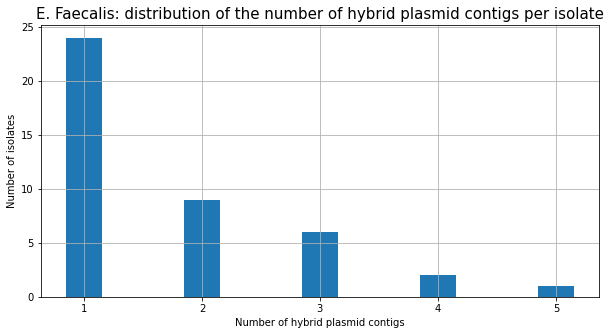

In [109]:
# Number of hybrid plasmid ontigs per isolate with at least one
EFAECALIS_PLASMIDS_CTGS_labels, EFAECALIS_PLASMIDS_CTGS_counts = np.unique(EFAECALIS_PLASMIDS['SRA'].value_counts(), return_counts=True)
figure1 = plt.figure(figsize=(10,5))
plt.title('E. Faecalis: distribution of the number of hybrid plasmid contigs per isolate', fontsize=15)
plt.xlabel('Number of hybrid plasmid contigs')
plt.ylabel('Number of isolates')
plt.bar(labels, EFAECALIS_PLASMIDS_CTGS_counts, align='center', width=0.3)
plt.grid()
plt.gca().set_xticks(labels)
plt.show()

##### Length distribution of circular contigs

In [110]:
CIRCULAR_CONTIGS = EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS['circularity'] == 1)]
CIRCULAR_CONTIGS_CHROM = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'chromosome']
CIRCULAR_CONTIGS_PLASMIDS = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'plasmid']

In [111]:
print(f'Over all E. faecalis isolates there are {len(CIRCULAR_CONTIGS)} hybrid circular contigs')
print(f'  {len(CIRCULAR_CONTIGS_CHROM)} are classified as chromosome')
print(f'  {len(CIRCULAR_CONTIGS_PLASMIDS)} are classified as plasmid')

Over all E. faecalis isolates there are 97 hybrid circular contigs
  24 are classified as chromosome
  73 are classified as plasmid


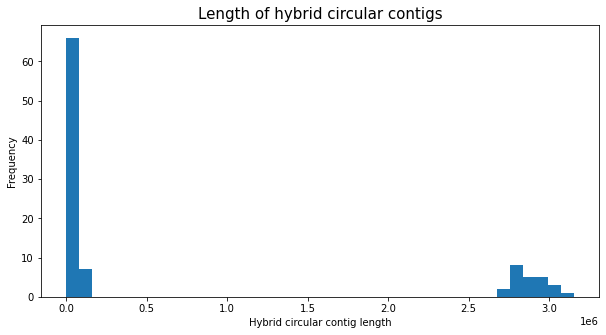

In [112]:
ax2 = CIRCULAR_CONTIGS.hist(column=["contig_length"], bins=40, figsize=(10,5))
plt.title('Length of hybrid circular contigs', fontsize=15)
plt.xlabel('Hybrid circular contig length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The above plot suggests that a threshold of 300000 bp separates plasmidic contigs from chromosomal ones.

In [113]:
EFAECALIS_THRESHOLD = 300000

##### Distribution of contig lengths per class

In [114]:
#Re-assigning labels to non-circular contigs smaller than the threshold as 'ambiguous'
for i, row in EFAECALIS_CONTIGS.iterrows():
    if (EFAECALIS_CONTIGS.loc[i,'classification'] == 'chromosome') & (EFAECALIS_CONTIGS.loc[i,'contig_length'] <= EFAECALIS_THRESHOLD):
        EFAECALIS_CONTIGS.at[i,'classification'] = 'ambiguous'     

Hybrid contig length distribution per class


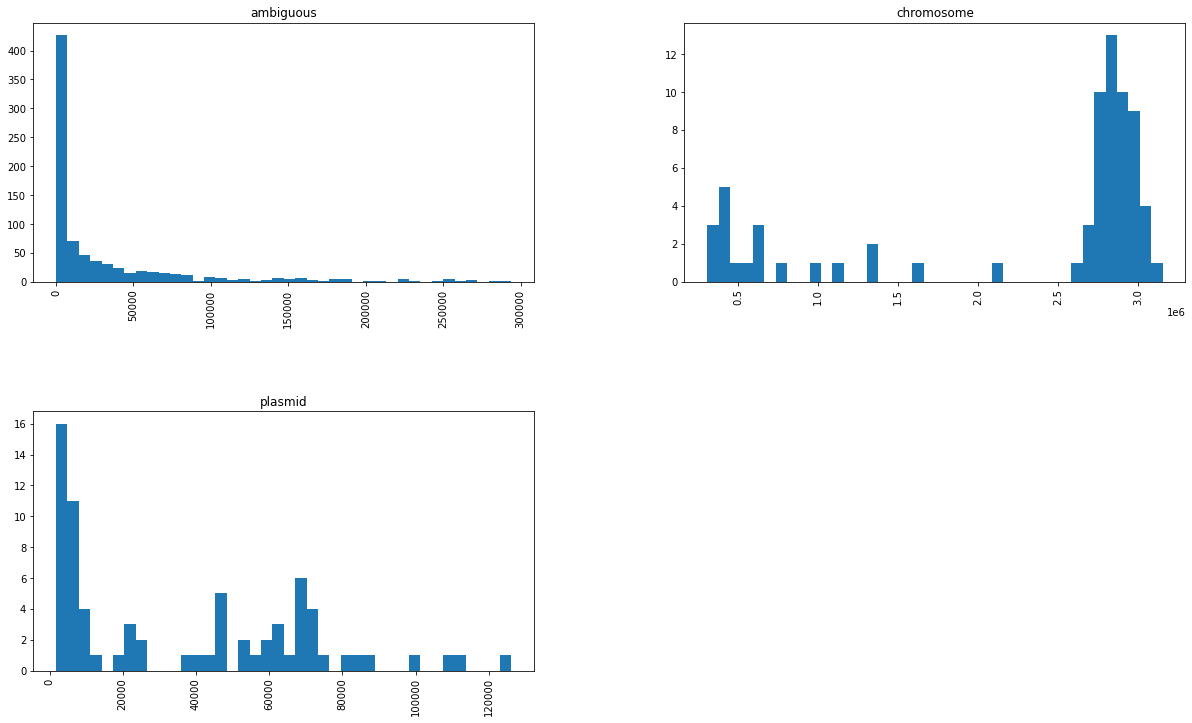

In [118]:
print(f'Hybrid contig length distribution per class')
ax3 = EFAECALIS_CONTIGS_LEN.hist(by="classification", bins=40, figsize=(20, 12))

In [116]:
nb_short_contigs = len(EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS["contig_length"] <= EFAECALIS_THRESHOLD)])
nb_short_ambig_contigs = len(EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS["contig_length"] <= EFAECALIS_THRESHOLD) & (EFAECALIS_CONTIGS['classification'] == 'ambiguous')])
print(f'{nb_short_contigs} out of {EFAECALIS_CONTIGS_NB} contigs are under {EFAECALIS_THRESHOLD} bp in length and {nb_short_ambig_contigs} of these contigs have been classified as ambiguous.')

887 out of 958 contigs are under 300000 bp in length and 814 of these contigs have been classified as ambiguous.


This shows that a very large number of shor contigs could as well be considered as partial plasmids or chromosomes. These contigs create a serious problem to assess the accuracy of plasmid contigs detection methods.

MORE TO ADD?

### E. faecium

Repeat the structure of the previous section.

##### Number of E. faecium contigs

In [126]:
EFAECIUM_CONTIGS = pd.read_csv('ctg_details_Efaecium.csv')
len(EFAECIUM_CONTIGS)

3538

##### Contigs classified as plasmids

In [127]:
EFAECIUM_PLASMIDS = EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS['classification'] == 'plasmid')]
EFAECIUM_PLASMIDS

,SRA,contig,contig_length,circularity,classification
51,SRR14010955,52,11206,1,plasmid
58,SRR14010955,59,7295,1,plasmid
65,SRR14010955,66,5087,1,plasmid
66,SRR14010955,67,4460,1,plasmid
73,SRR14010955,74,3221,1,plasmid
...,...,...,...,...,...
3366,SRR14024983,6,5254,1,plasmid
3383,SRR14022777,7,32924,1,plasmid
3448,SRR14010961,63,6173,1,plasmid
3454,SRR14010961,69,5201,1,plasmid


In [128]:
len(EFAECIUM_PLASMIDS['SRA'].value_counts())

59

Text(0.5, 1.0, 'Number of hybrid contigs labelled as plasmids vs Frequency of isolates')

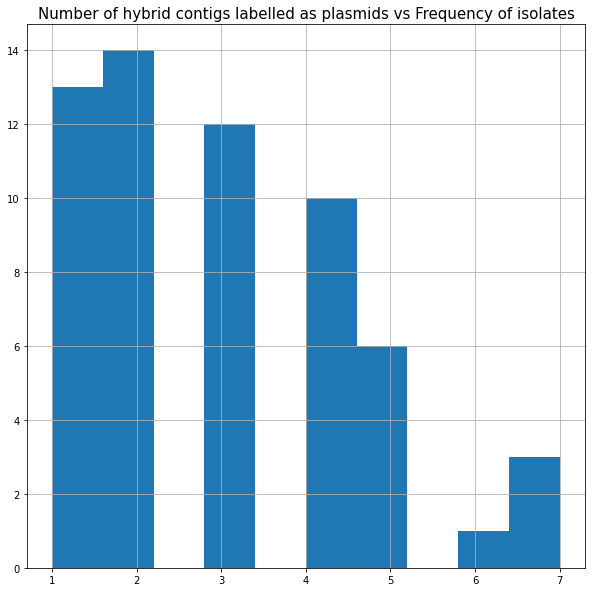

In [129]:
EFAECIUM_PLASMIDS['SRA'].value_counts().hist()
plt.title('Number of hybrid contigs labelled as plasmids vs Frequency of isolates', fontsize=15)

Thus, 59 isolates contain contigs that have been classified as plasmids using the current criteria. 12 isolates have no contigs to represent the ground truth plasmids. A total of 174 out of 3538 contigs are classified as plasmids.

##### Length distribution of circular contigs 

In [130]:
CIRCULAR_CONTIGS = EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS['circularity'] == 1)]

In [131]:
len(CIRCULAR_CONTIGS)

187

In [132]:
len(CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'chromosome'])

13

Text(0.5, 1.0, 'Length of hybrid circular contigs')

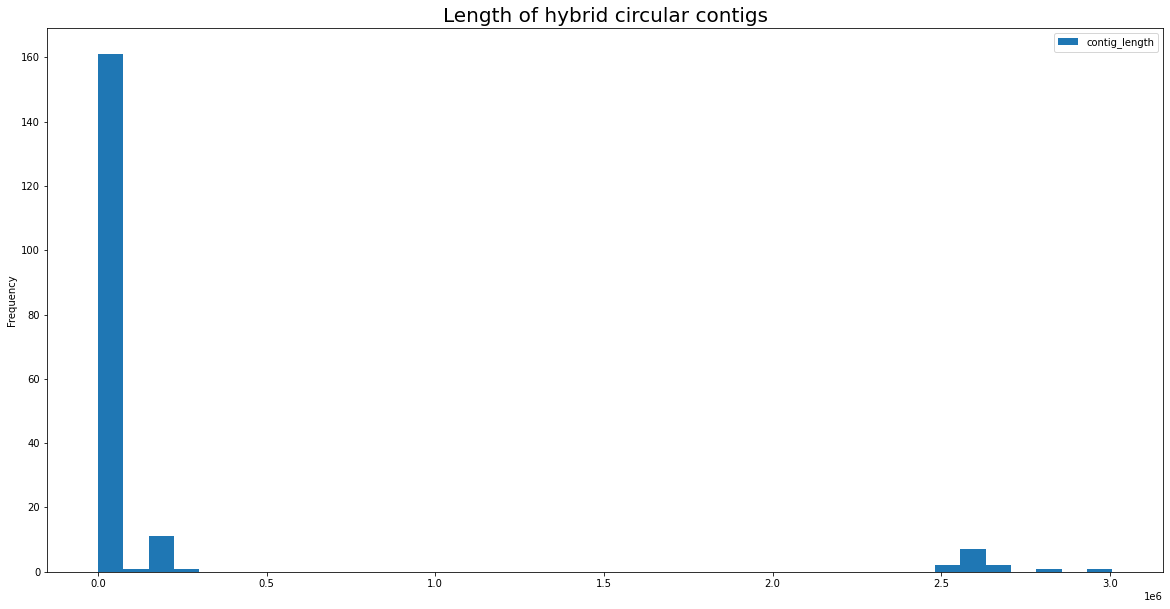

In [134]:
ax = CIRCULAR_CONTIGS.plot.hist(column=["contig_length"], bins=40, figsize=(20, 10))
plt.title('Length of hybrid circular contigs', fontsize=20)

There are 187 circular contigs of which only 13 are chromosomal. The above plot suggests that a threshold of 300000 bp separates plasmidic contigs from chromosomal ones.

##### Distribution of contig lengths for plasmidic and chromosomal contigs

In [135]:
#Re-assigning labels to non-circular contigs smaller than the threshold as 'ambiguous'
for i, row in EFAECIUM_CONTIGS.iterrows():
    if (EFAECIUM_CONTIGS.loc[i,'classification'] == 'chromosome') & (EFAECIUM_CONTIGS.loc[i,'contig_length'] <= 300000):
        EFAECIUM_CONTIGS.at[i,'classification'] = 'ambiguous'

In [136]:
EFAECIUM_CONTIGS

,SRA,contig,contig_length,circularity,classification
0,SRR14010955,1,300900,0,chromosome
1,SRR14010955,2,222935,0,ambiguous
2,SRR14010955,3,218223,0,ambiguous
3,SRR14010955,4,190024,0,ambiguous
4,SRR14010955,5,165277,0,ambiguous
...,...,...,...,...,...
3533,SRR14010961,148,445,0,ambiguous
3534,SRR14010961,149,403,0,ambiguous
3535,SRR14010961,150,402,0,ambiguous
3536,SRR14010961,151,383,0,ambiguous


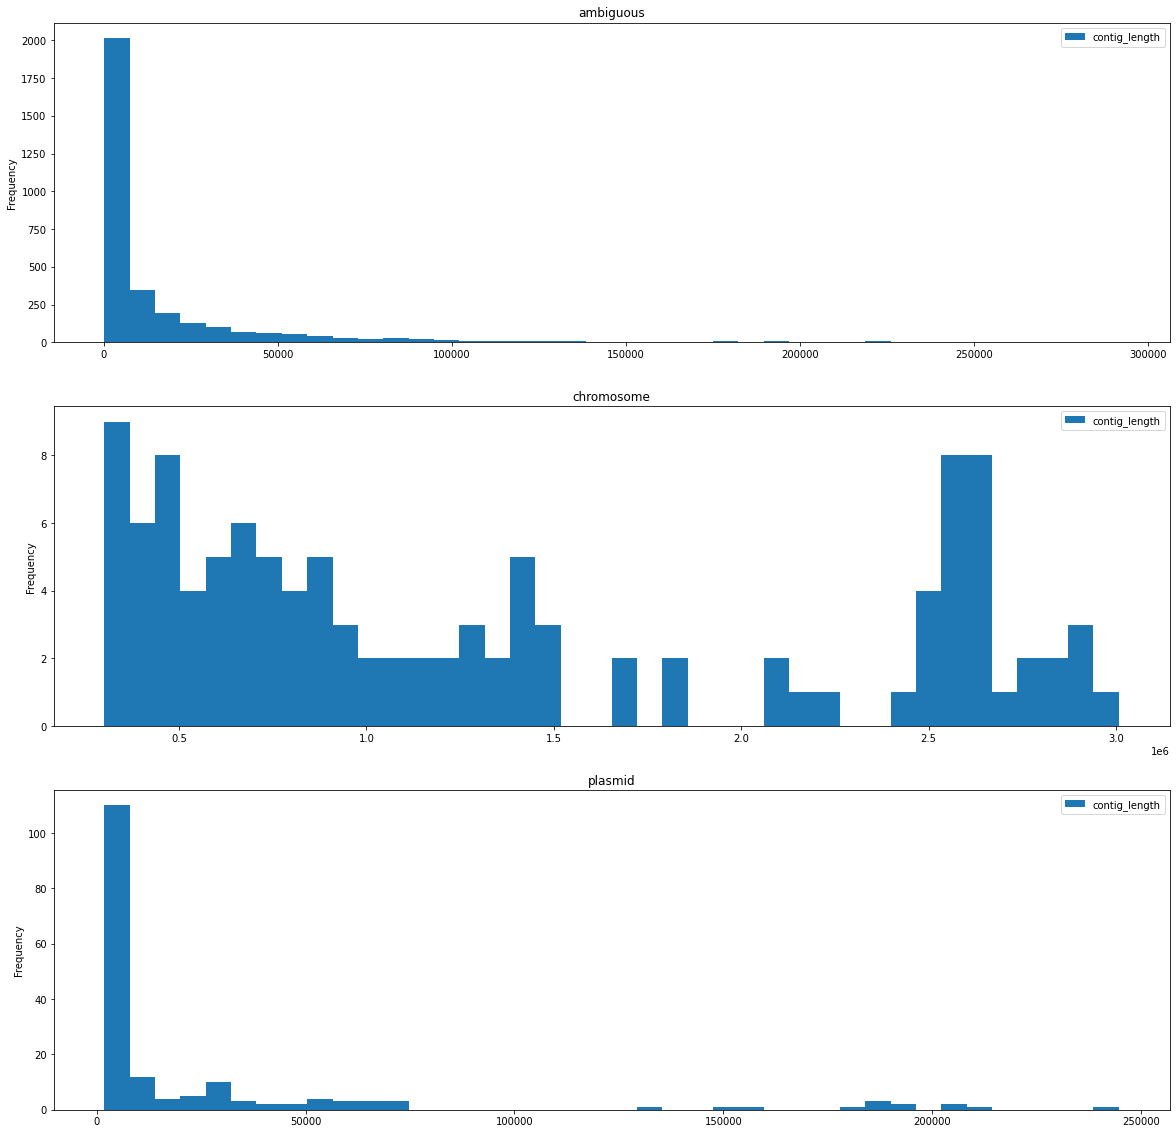

In [137]:
ax = EFAECIUM_CONTIGS.plot.hist(column=["contig_length"], by="classification", bins=40, figsize=(20, 20))

In [138]:
len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= 300000)])

3424

In [139]:
len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= 1000)])

800

In [140]:
len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= 300000) & (EFAECIUM_CONTIGS["classification"] == "ambiguous")])

3250

3424 out of 3538 contigs are under 300000 bp in length and 3250 of these contigs have been classified as ambiguous. Almost all ambiguous contigs are under 150000 bp in length. Overall, 800 out of 3538 contigs are under 1000 bp in length. 

### Comparison against ground truth

We used PlasBin, HyAsP, MOB-recon and plasmidSPAdes to predict plasmids using the short read contigs and assembly graphs. Thus, we obtained plasmids as bins of short read contigs. We use hybrid contigs classified as plasmids to represent the ground truth plasmids. In order to compare the predictions against the ground truth, we obtain short read contig set representations of the hybrid contigs. We do so by mapping the short read contigs onto the hybrid contigs using minimap2. The hybrid contig mappings have been stored in the "data/Hybrid_Contigs_Plasmids". For each isolate, we then compare the predictions against the ground truth plasmid bins using PlasEval. We obtain a score that measures the dissimilarity between the ground truth and the predicted plasmid bins.

In [141]:
EFAECALIS_ISOLATES = pd.read_csv('isolate_details_Efaecalis.csv')
EFAECIUM_ISOLATES = pd.read_csv('isolate_details_Efaecium.csv')

#### E. faecalis

In [142]:
EFAECALIS_ISOLATES.loc[:, EFAECALIS_ISOLATES.columns != 'psp'][~EFAECALIS_ISOLATES.loc[:, EFAECALIS_ISOLATES.columns != 'psp'].isnull().any(axis=1)]

,Unnamed: 0,nb_plasmid_ctg,len_plasmid_ctg,nb_ctg,len_ctg,nb_short_ctg,pb,hy,mob
0,SRR14000614,1.0,81219.0,83.0,4739395.0,21.0,0.657104,0.876595,1.000000
3,SRR13727011,0.0,0.0,64.0,3157018.0,37.0,1.000000,1.000000,1.000000
5,SRR13999927,1.0,4802.0,49.0,4077773.0,13.0,0.973767,1.000000,0.879492
6,SRR13726551,0.0,0.0,45.0,3595865.0,3.0,1.000000,1.000000,1.000000
7,SRR13999934,4.0,20126.0,45.0,2854750.0,5.0,0.644795,0.998424,0.727814
8,SRR13727008,1.0,5121.0,34.0,2890077.0,9.0,1.000000,0.996637,0.976028
9,SRR13712363,1.0,3120.0,26.0,2835206.0,4.0,1.000000,0.960782,0.942801
10,SRR14000594,1.0,25486.0,26.0,3047410.0,13.0,0.850237,0.978424,1.000000
11,SRR13725703,0.0,0.0,22.0,3037683.0,10.0,1.000000,1.000000,1.000000
12,SRR13726554,1.0,5143.0,22.0,3039453.0,5.0,0.895146,0.989981,0.500000


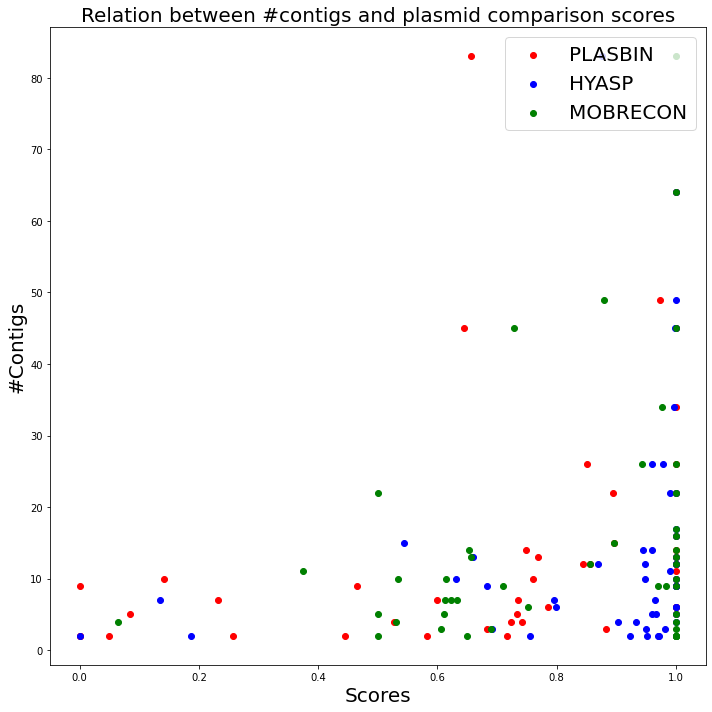

In [143]:
plt.title('Relation between #contigs and plasmid comparison scores',fontsize=20)
plt.xlabel('Scores',fontsize=20)
plt.ylabel('#Contigs',fontsize=20)

plt.scatter(x=EFAECALIS_ISOLATES['pb'],y=EFAECALIS_ISOLATES['nb_ctg'],color='red',label='PLASBIN')
plt.scatter(x=EFAECALIS_ISOLATES['hy'],y=EFAECALIS_ISOLATES['nb_ctg'],color='blue',label='HYASP')
plt.scatter(x=EFAECALIS_ISOLATES['mob'],y=EFAECALIS_ISOLATES['nb_ctg'],color='green',label='MOBRECON')
#plt.scatter(x=EFAECALIS_ISOLATES['psp'],y=EFAECALIS_ISOLATES['nb_ctg'],color='black',label='PSPADES')

plt.legend(loc='upper right',fontsize=20)
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
 
plt.show()

From this plot, we can see very few scores below 0.5. This suggests that the ground truth is dissimilar to the predicted plasmid bins. Furthermore, if the isolate contains more than 20 hybrid contigs, the dissimilarity score is almost always above 0.5. There is no clear indication as to which tool performs better in terms of similarity to the ground truth.

#### E. faecium

In [144]:
EFAECIUM_ISOLATES.loc[:, EFAECIUM_ISOLATES.columns != 'psp'][~EFAECIUM_ISOLATES.loc[:, EFAECIUM_ISOLATES.columns != 'psp'].isnull().any(axis=1)]

,Unnamed: 0,nb_plasmid_ctg,len_plasmid_ctg,nb_ctg,len_ctg,nb_short_ctg,pb,hy,mob
1,SRR14010969,4.0,16436.0,188.0,2802093.0,23.0,0.976618,0.993948,1.000000
2,SRR14011002,4.0,12994.0,177.0,3177305.0,38.0,0.980554,0.995170,0.959984
3,SRR14026515,2.0,9547.0,172.0,2759510.0,26.0,0.969272,1.000000,1.000000
4,SRR14010946,2.0,8837.0,169.0,3277448.0,29.0,1.000000,1.000000,0.986474
5,SRR14011041,3.0,15375.0,169.0,3325859.0,26.0,0.984311,0.995162,0.962286
6,SRR14010961,3.0,15839.0,152.0,3088663.0,32.0,1.000000,0.995275,1.000000
7,SRR14022770,0.0,0.0,143.0,2895770.0,70.0,1.000000,1.000000,1.000000
8,SRR14022782,1.0,1799.0,132.0,5089904.0,48.0,1.000000,0.926632,1.000000
11,SRR14010955,5.0,31269.0,107.0,3320391.0,9.0,0.971016,0.994919,0.918569
13,SRR14024950,0.0,0.0,92.0,3428202.0,38.0,1.000000,1.000000,1.000000


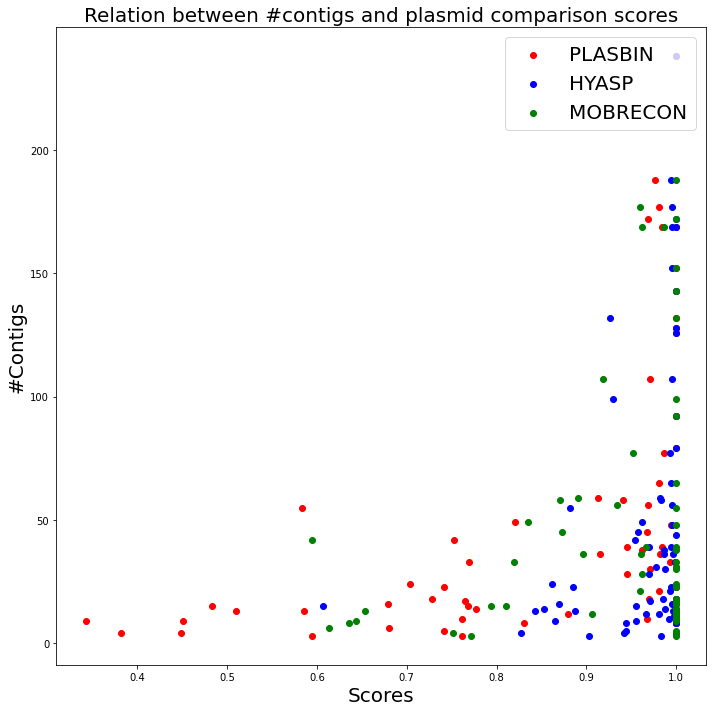

In [145]:
plt.title('Relation between #contigs and plasmid comparison scores',fontsize=20)
plt.xlabel('Scores',fontsize=20)
plt.ylabel('#Contigs',fontsize=20)

plt.scatter(x=EFAECIUM_ISOLATES['pb'],y=EFAECIUM_ISOLATES['nb_ctg'],color='red',label='PLASBIN')
plt.scatter(x=EFAECIUM_ISOLATES['hy'],y=EFAECIUM_ISOLATES['nb_ctg'],color='blue',label='HYASP')
plt.scatter(x=EFAECIUM_ISOLATES['mob'],y=EFAECIUM_ISOLATES['nb_ctg'],color='green',label='MOBRECON')
#plt.scatter(x=EFAECALIS_ISOLATES['psp'],y=EFAECALIS_ISOLATES['nb_ctg'],color='black',label='PSPADES')

plt.legend(loc='upper right',fontsize=20)
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
 
plt.show()

From this plot, we can see very few scores below 0.5. In fact, all tools consistently have predictions that have a dissimilarity score >= 0.5, with the exception of PlasBin. For isolates having more than 50 contigs, the dissimilarity score is almost always greater than 0.6. 

The high level of dissimilarity from all the tools can be explained by the lack of representation of plasmidic hybrid contigs in the dataset. It is likely that the plasmids have been fragemented into smaller linear contigs. As a result, these contigs are misclassified. This can be especially observed in isolates with high number of contigs.